In [1]:
!pip install minisom

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# !pip install minisom
from minisom import MiniSom

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [3]:
def som_pie_grid(som, data, labels):
  """Helper to create piechart grid viz
  
  Example: https://raw.githubusercontent.com/JustGlowing/minisom/master/examples/resulting_images/som_iris_pies.png

  :param som: fitted MiniSom instance
  :param data: the data the MiniSom was fit to
  :param labels: an array of labels to use for coloring visual
  """
  labels_map = som.labels_map(data, labels)
  label_names = np.unique(labels)

  plt.figure(figsize=(70, 70))
  the_grid = GridSpec(70, 70)
  for position in labels_map.keys():
      label_fracs = [labels_map[position][lab] for lab in label_names]
      plt.subplot(the_grid[position[1] - 12, position[0]], aspect=1)
      patches, texts = plt.pie(label_fracs)

  plt.show()

  # Cheating way to align legend, create a separate figure just 
  # for legend.  Will have superfluous whitespace below
  plt.legend(patches, label_names, loc='upper left', ncol=5)
  plt.axis('off')
  plt.show()

* Read in the data from `data_url`
* Drop all NAs
* Filter based on the `'Pos'` column to where only have the positions `['C', 'PG', 'SG']` remain
* Drop all non-numeric columns
* Scale the data

In [4]:
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/nba_player_seasons.csv"

In [5]:
df = pd.read_csv(data_url)

In [6]:
df.isnull().sum()[lambda x:x>0]

FG%      10
3P%     174
2P%      31
eFG%     10
FT%     104
dtype: int64

In [7]:
# drop nulls
df = df.dropna()
# select positions ['C', 'PG', 'SG'] from 'Pos' column
df = df.loc[df['Pos'].isin(['C', 'PG', 'SG'])]

In [8]:
df['Pos'].value_counts()

SG    458
PG    410
C     286
Name: Pos, dtype: int64

In [9]:
#Drop all numeric columns
df.dtypes

Seas        int64
Player     object
Pos        object
Age         int64
Tm         object
G           int64
GS          int64
MP        float64
FG        float64
FGA       float64
FG%       float64
3P        float64
3PA       float64
3P%       float64
2P        float64
2PA       float64
2P%       float64
eFG%      float64
FT        float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
TRB       float64
AST       float64
STL       float64
BLK       float64
TOV       float64
PF        float64
PTS       float64
dtype: object

In [10]:
X = df.select_dtypes(exclude='O')
y = df.Pos
X

,Seas,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,25,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
2,2019,22,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,0.4,1.1,0.361,0.459,0.2,0.3,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,2019,25,80,80,33.4,6.0,10.1,0.595,0.0,0.0,0.000,6.0,10.1,0.596,0.595,1.8,3.7,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,2019,21,82,28,23.3,3.4,5.9,0.576,0.0,0.2,0.200,3.4,5.7,0.588,0.579,2.0,2.8,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
6,2019,25,7,0,3.1,0.4,1.4,0.300,0.0,0.6,0.000,0.4,0.9,0.500,0.300,0.1,0.3,0.500,0.1,0.4,0.6,0.9,0.3,0.0,0.3,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,2016,22,8,3,18.0,2.8,8.1,0.338,0.4,2.1,0.176,2.4,6.0,0.396,0.362,2.5,4.6,0.541,0.3,2.4,2.6,2.5,0.4,0.0,3.6,1.4,8.4
2135,2016,20,29,0,6.9,0.4,1.2,0.306,0.2,0.9,0.231,0.2,0.3,0.500,0.389,0.0,0.1,0.250,0.1,0.8,0.9,0.3,0.2,0.0,0.2,0.6,1.0
2136,2016,23,41,0,9.4,1.5,4.1,0.367,0.2,1.1,0.217,1.3,3.0,0.423,0.396,0.5,0.6,0.800,0.1,1.1,1.2,1.6,0.4,0.0,0.8,0.7,3.8
2137,2016,30,54,2,19.1,2.3,6.9,0.339,1.4,4.4,0.325,0.9,2.5,0.363,0.442,1.2,1.4,0.829,0.3,1.5,1.8,0.6,0.4,0.1,0.6,0.9,7.3


In [11]:
y

0       SG
2       PG
3        C
4        C
6       SG
        ..
2134    PG
2135    SG
2136    PG
2137    SG
2139     C
Name: Pos, Length: 1154, dtype: object

In [12]:
scale = StandardScaler()
X_scale = scale.fit_transform(X)
X_scale

array([[ 1.32732759, -0.30185086, -0.92898999, ..., -0.91267424,
        -0.07384695, -0.6525346 ],
       [ 1.32732759, -1.01614182, -0.80531519, ..., -0.55829131,
        -0.62012501, -1.00104968],
       [ 1.32732759, -0.30185086,  1.09103185, ...,  0.50485749,
         1.1552787 ,  0.77471765],
       ...,
       [-1.42264734, -0.77804484, -0.51674064, ..., -0.55829131,
        -1.43954211, -0.90147394],
       [-1.42264734,  0.88863408,  0.01918353, ..., -0.7945466 ,
        -1.16640308, -0.32061547],
       [-1.42264734, -0.77804484,  0.8024573 , ..., -0.44016366,
         1.42841773, -0.08827208]])

* Fit a `MiniSom` instance to the scaled data
  * Choose your own grid size
  * Set a `random_seed` to have reproducible results
  * Initialize the `MiniSom` weight vectors using `.pca_weights_init()` or `.random_weights_init()`
  * Train the model using `.train_random()` or `.train_batch()`

In [13]:
grid_cols = 12
grid_rows = 10
n_cols = X.shape[1]

som = MiniSom(x=grid_cols, y=grid_rows, input_len=n_cols, random_seed=42)
som.pca_weights_init(X_scale)
som.train_random(X_scale, num_iteration=200, verbose=True)

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 3.0210196807557836


* Use the helper function defined at the top of the notebook to plot the SOM's fit
  * Use the players' positions (the `'Pos'` column) as the labels in the viz
  * Experiment with the SOM's grid size, initialization method, and training method.  Decide a 'good' fit using this visual as guidance.

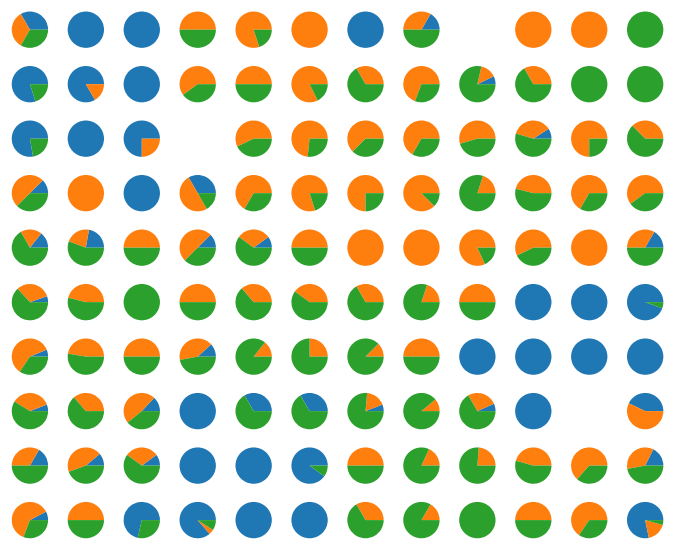

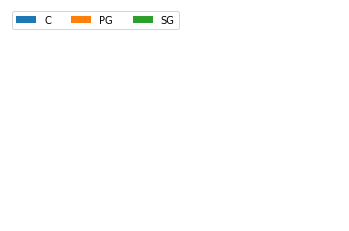

In [14]:
som_pie_grid(som, X_scale, y)

* Perform dimension reduction (to 2d) with another method (perhaps `PCA` or `TSNE`).
* Create a scatter plot of the results of this dimension reduction and color the scatter plot by the players' positions (the `'Pos'` column).
  * How do these results compare to that of the SOM? What are the pros and cons of the different approaches you took in this notebook?

In [15]:
pd.DataFrame(X_scale).isnull().sum()[lambda x:x>0]

Series([], dtype: int64)

In [16]:
X_scale.shape

(1154, 27)

In [17]:
y = y.reset_index(drop=True)

In [18]:
y

0       SG
1       PG
2        C
3        C
4       SG
        ..
1149    PG
1150    SG
1151    PG
1152    SG
1153     C
Name: Pos, Length: 1154, dtype: object

In [19]:
pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X_scale))
X_pca['Pos'] = y

px.scatter(data_frame=X_pca, x=0, y=1, color='Pos')

In [20]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scale)

In [21]:
fig = px.scatter(x=X_tsne[:,0], y=X_tsne[:,1], color=y)
fig.show()

They are similar results in that the C position is mostly unmixed and the other two positions were mixed.